In [1]:
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch

In [2]:
from pylissom.utils.training import Pipeline
from torch.utils.data import Dataset, DataLoader
from pylissom.datasets.datasets import OrientatedGaussians

In [3]:
from pylissom.models.models import get_lissom 
from pylissom.utils.plotting import *
from pylissom.utils.helpers import debug


%autosave 60
%load_ext line_profiler
%load_ext memory_profiler

Autosaving every 60 seconds


In [4]:
import torch
torch.cuda.is_available()

True

In [5]:
foo = torch.Tensor(2)

###### If this takes more than 5 seconds, dont worry, it's a problem with the pytorch and cuda versions, only happens first time cuda is called

In [6]:
%time foo.cuda()

CPU times: user 2min 21s, sys: 1.58 s, total: 2min 22s
Wall time: 2min 22s



-2.5904e-17
 4.5855e-41
[torch.cuda.FloatTensor of size 2 (GPU 0)]

## Training variables

In [7]:
size = 24
count = 10000
epochs = 1
cuda = True
gaussians_per_image = 1

## Init and train Lissom

In [30]:
lissom, optimizer, _ = get_lissom(retinal_density=size, lgn_params='lgn', rlissom_params='rlissom', optim_params='optim')
display(lissom)

Lissom (
  (v1): ReducedLissom (
    (inhibitory_module): Cortex (9216 -> 9216, sigma=47.84, radius=23.0)
    (excitatory_module): Cortex (9216 -> 9216, sigma=7.4879999999999995, radius=9.6)
    (afferent_module): Cortex (576 -> 9216, sigma=5.0, radius=6.5)
    (piecewise_sigmoid): PiecewiseSigmoid (min_theta=0.083, max_theta=0.633)
  , 576 -> 9216, settling_steps=9, afferent_strength=1.0, excitatory_strength=0.9, inhibitory_strength=0.9)
  (off): LGN (
    (diff_of_gaussians): DifferenceOfGaussiansLinear (576 -> 576, sigma_surround=2.0, sigma_center=0.5, radius=9.4, on=False)
    (strength): *2.33
    (piecewise_sigmoid): PiecewiseSigmoid (min_theta=0.0, max_theta=1.0)
  )
  (on): LGN (
    (diff_of_gaussians): DifferenceOfGaussiansLinear (576 -> 576, sigma_surround=2.0, sigma_center=0.5, radius=9.4, on=True)
    (strength): *2.33
    (piecewise_sigmoid): PiecewiseSigmoid (min_theta=0.0, max_theta=1.0)
  )
, 576 -> 9216)

In [9]:
gaussians_inputs = OrientatedGaussians(size=size, length=count, gaussians=gaussians_per_image, 
                                       save_first=True, cache_path='gaussianas.npy')
gaussians_inputs.cuda()
train_loader = DataLoader(gaussians_inputs, shuffle=True, pin_memory=False)

In [31]:
pipe = Pipeline(lissom, optimizer, cuda=cuda, log_interval=10)

## Inpect activation

In [11]:
from pylissom.nn.modules.lissom import *

In [12]:
from pylissom.nn.functional.functions import piecewise_sigmoid

In [13]:
%lprun -f pipe._run -f Lissom.__call__ -f ReducedLissom.__call__ -f ReducedLissom.forward -f Lissom.forward -f Cortex.forward -f Cortex.__call__ -f piecewise_sigmoid pipe.train(train_loader, epochs)

*** KeyboardInterrupt exception caught in code being profiled.

In [ ]:
%prun pipe.train(train_loader, epochs)

In [14]:
%mprun -f pipe._run -f Lissom.__call__ -f ReducedLissom.__call__ -f ReducedLissom.forward -f Lissom.forward -f Cortex.forward -f Cortex.__call__ -f piecewise_sigmoid pipe.train(train_loader, epochs)

*** KeyboardInterrupt exception caught in code being profiled.


In [ ]:
gauss, _ = iter(train_loader).next()
plot_tensor(gauss, (size, size), vmin=-1, vmax=1)

In [ ]:
gauss.is_cuda

In [ ]:
train_loader.pin_memory

In [ ]:
from pylissom.nn.modules.lissom import *

register_recursive_forward_hook(lissom, input_output_hook)
inp = Pipeline.process_input(torch.autograd.Variable(gauss).cuda())
out = lissom(inp)
plot_layer_activation(lissom, 'lissom')

## Train

In [ ]:
pipe.train(train_loader, epoch=0)

## Calculate Orientations Maps

In [37]:
from pylissom.utils.orientation_maps import *
orientations = 180

keys_arrays = get_oriented_lines(size, orientations=orientations)

In [38]:
keys_arrays = {k: map(lambda l: torch.autograd.Variable(l.cuda()), lines) for k, lines in keys_arrays.items()}

In [39]:
om = OrientationMap(model=lissom, inputs=keys_arrays)

orientation_map = om.get_orientation_map()
orientation_hist = om.get_orientation_hist()

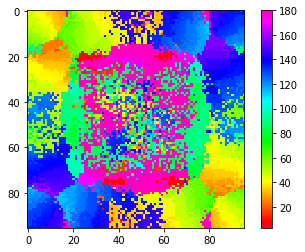

In [40]:
plot_orientation_map(orientation_map)
plt.colorbar()
plt.show()

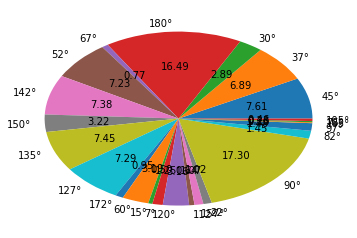

Promedio: %4.17
Standard deviation: %4.67


In [36]:
plot_orientation_hist(orientation_hist)
plt.show()

mean, std = metrics_orientation_hist(orientation_hist)
print("Promedio: %{:.2f}".format(mean*100))
print("Standard deviation: %{:.2f}".format(std*100))